In [31]:
import pandas as pd


df = pd.read_excel('./separated-data/cpu-usage-all.xlsx')
df


,delta-time,service,repetition 1,repetition 2,repetition 3,repetiton 4,avg,max,min,Desviacion Standard,p95,p99
0,0,neo4j-database,0.006111,0.386608,0.419189,0.438848,0.312689,0.438848,0.006111,0.177984,0.435899,0.438258
1,10,neo4j-database,0.024827,0.402727,0.435423,0.438112,0.325272,0.438112,0.024827,0.174020,0.437708,0.438031
2,20,neo4j-database,0.027338,0.402727,0.435423,0.438112,0.325900,0.438112,0.027338,0.172937,0.437708,0.438031
3,30,neo4j-database,0.125266,0.402727,0.435423,0.438112,0.350382,0.438112,0.125266,0.130715,0.437708,0.438031
4,40,neo4j-database,0.125266,0.386199,0.418628,0.448350,0.344611,0.448350,0.125266,0.128532,0.443892,0.447458
...,...,...,...,...,...,...,...,...,...,...,...,...
149,170,open-telemetry-tempo,0.001723,0.002193,0.002560,0.000816,0.001823,0.002560,0.000816,0.000653,0.002505,0.002549
150,180,open-telemetry-tempo,0.000874,0.001924,0.002487,0.001272,0.001639,0.002487,0.000874,0.000617,0.002403,0.002470
151,190,open-telemetry-tempo,0.001530,0.001986,0.002340,0.001272,0.001782,0.002340,0.001272,0.000411,0.002287,0.002329
152,200,open-telemetry-tempo,0.001530,0.001909,0.002235,0.001504,0.001794,0.002235,0.001504,0.000301,0.002186,0.002225


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

def process(services: List[str], title: str, df: pd.DataFrame):
    """
    Genera un gráfico que muestra la media y desviación estándar por servicio,
    con una línea de regresión general superpuesta.
    """
    service1, service2 = services[0], services[1]
    df_filtered = df[df['service'].isin([service1, service2])].copy()

    # Dividir el tiempo en intervalos para poder comparar
    max_time = df_filtered['delta-time'].max()
    bins = np.arange(0, max_time + 10, 10) # Bins de 10 segundos
    df_filtered['time_bin'] = pd.cut(df_filtered['delta-time'], bins=bins)
    
    # Calcular la media de 'avg' y 'Desviacion Standard' para cada bin
    stats_binned = df_filtered.groupby(['service', 'time_bin']).agg(
        mean_avg=('avg', 'mean'),
        mean_std=('Desviacion Standard', 'mean')
    ).reset_index()

    # Pivotar la tabla para tener las estadísticas de cada servicio en columnas separadas
    stats_pivot = stats_binned.pivot(index='time_bin', columns='service', values=['mean_avg', 'mean_std'])
    stats_pivot.dropna(inplace=True) # Eliminar bins donde un servicio no tenga datos

    # --- 2. Encontrar Diferencias Significativas (Heurística de no solapamiento) ---
    
    # Calcular los límites superior e inferior para cada servicio
    stats_pivot['lower_s1'] = stats_pivot[('mean_avg', service1)] - stats_pivot[('mean_std', service1)]
    stats_pivot['upper_s1'] = stats_pivot[('mean_avg', service1)] + stats_pivot[('mean_std', service1)]
    stats_pivot['lower_s2'] = stats_pivot[('mean_avg', service2)] - stats_pivot[('mean_std', service2)]
    stats_pivot['upper_s2'] = stats_pivot[('mean_avg', service2)] + stats_pivot[('mean_std', service2)]

    # Identificar los bins donde los rangos NO se solapan
    significant_bins = stats_pivot[
        (stats_pivot['upper_s1'] < stats_pivot['lower_s2']) | 
        (stats_pivot['upper_s2'] < stats_pivot['lower_s1'])
    ].index

    # --- 3. Graficar ---
    fig, ax = plt.subplots(figsize=(15, 8))

    # Dibujar la media y la desviación estándar para cada servicio
    for service in [service1, service2]:
        service_stats = stats_binned[stats_binned['service'] == service]
        x = service_stats['time_bin'].apply(lambda b: b.mid)
        mean = service_stats['mean_avg']
        std = service_stats['mean_std']
        
        line, = ax.plot(x, mean, linestyle="-", label=f"{service} Mean")
        ax.fill_between(x, mean - std, mean + std, alpha=0.2, color=line.get_color())

    # Sombrear las áreas con diferencias significativas
    for time_bin in significant_bins:
        ax.axvspan(time_bin.left, time_bin.right, color='red', alpha=0.25, label='Diferencia Significativa')

    # --- 4. Finalizar el Gráfico ---
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Delta Time (seconds)", fontsize=12)
    ax.set_ylabel("Average Value", fontsize=12)
    
    # Consolidar la leyenda para evitar etiquetas duplicadas
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), title='Leyenda')

    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [33]:
sample_service_keys = ["sample-service", "sample-service-tempo"]
backend_service_keys = ['tempo', 'neo4j-database', 'custom-collector']
collectors_service_keys = ['open-telemetry','open-telemetry-tempo']

/var/folders/rh/j4bhqmdj3wxd1_tlvbyqdsrc0000gn/T/ipykernel_70673/2395979386.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_binned = df_filtered.groupby(['service', 'time_bin']).agg(


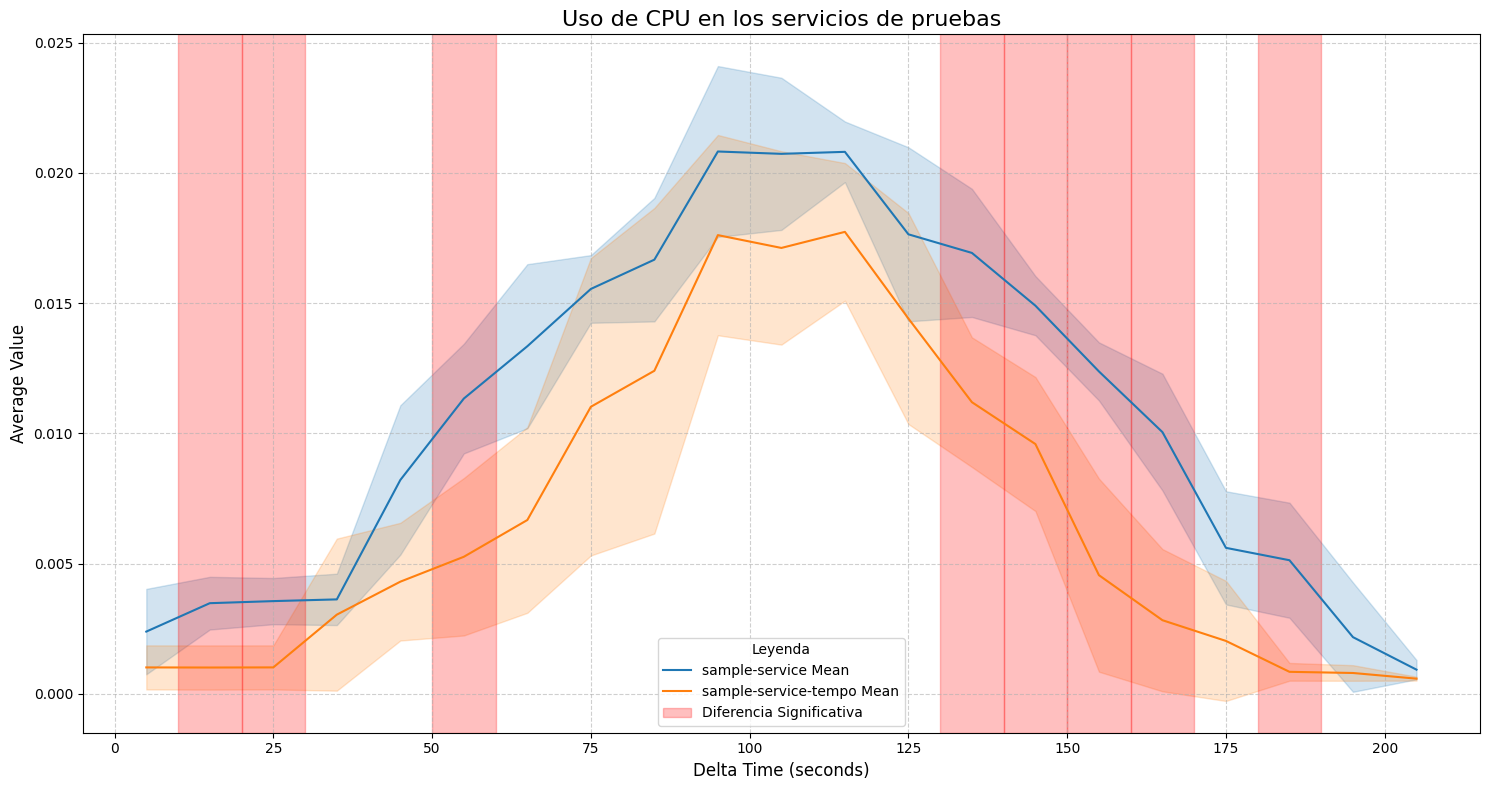

Empty DataFrame
Columns: []
Index: []


In [34]:
# Get a list of the unique services
process(sample_service_keys, "Uso de CPU en los servicios de pruebas", df)

/var/folders/rh/j4bhqmdj3wxd1_tlvbyqdsrc0000gn/T/ipykernel_70673/2395979386.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_binned = df_filtered.groupby(['service', 'time_bin']).agg(


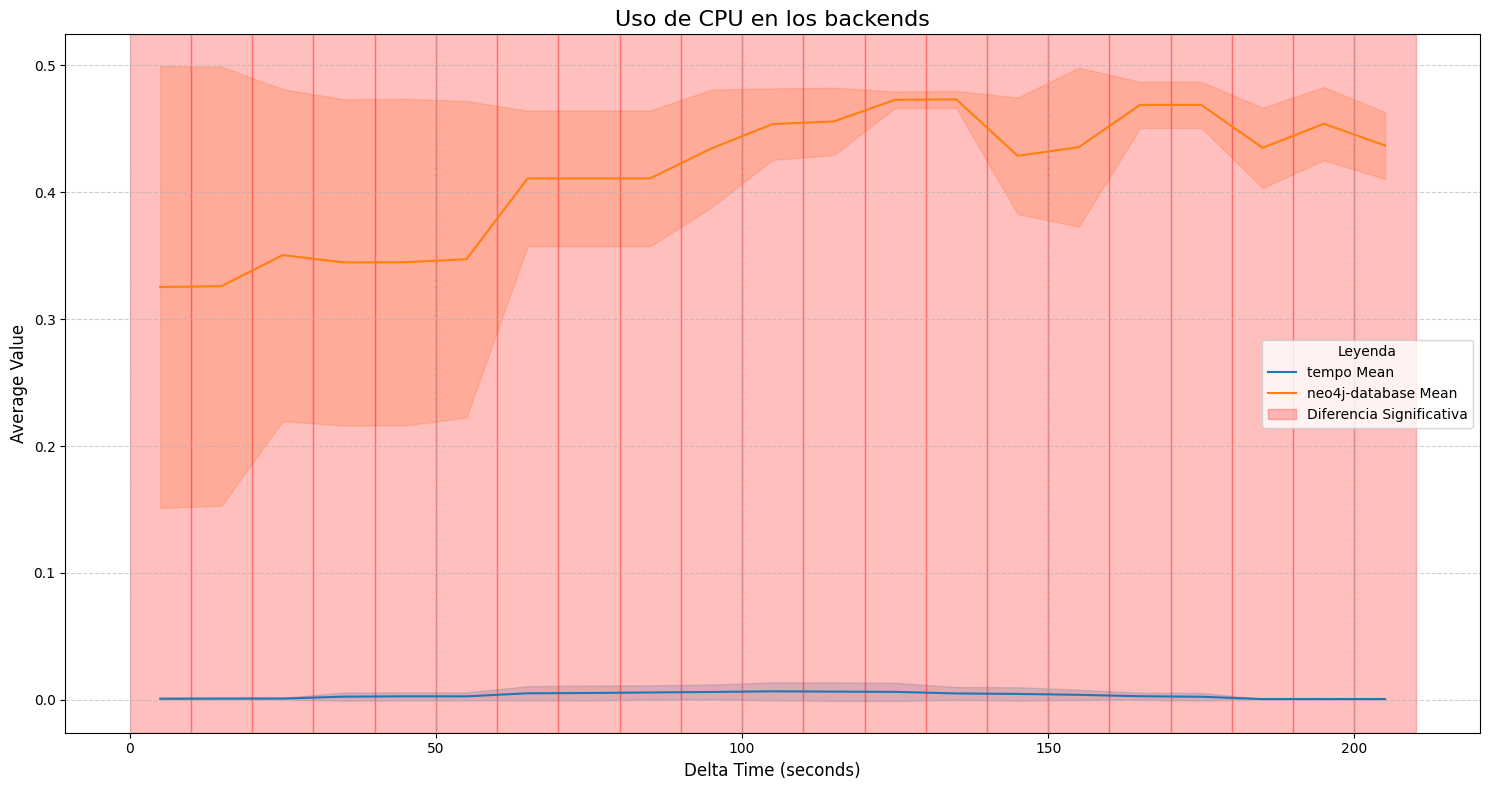

Empty DataFrame
Columns: []
Index: []


In [35]:
process(backend_service_keys, 'Uso de CPU en los backends', df)

/var/folders/rh/j4bhqmdj3wxd1_tlvbyqdsrc0000gn/T/ipykernel_70673/2395979386.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_binned = df_filtered.groupby(['service', 'time_bin']).agg(


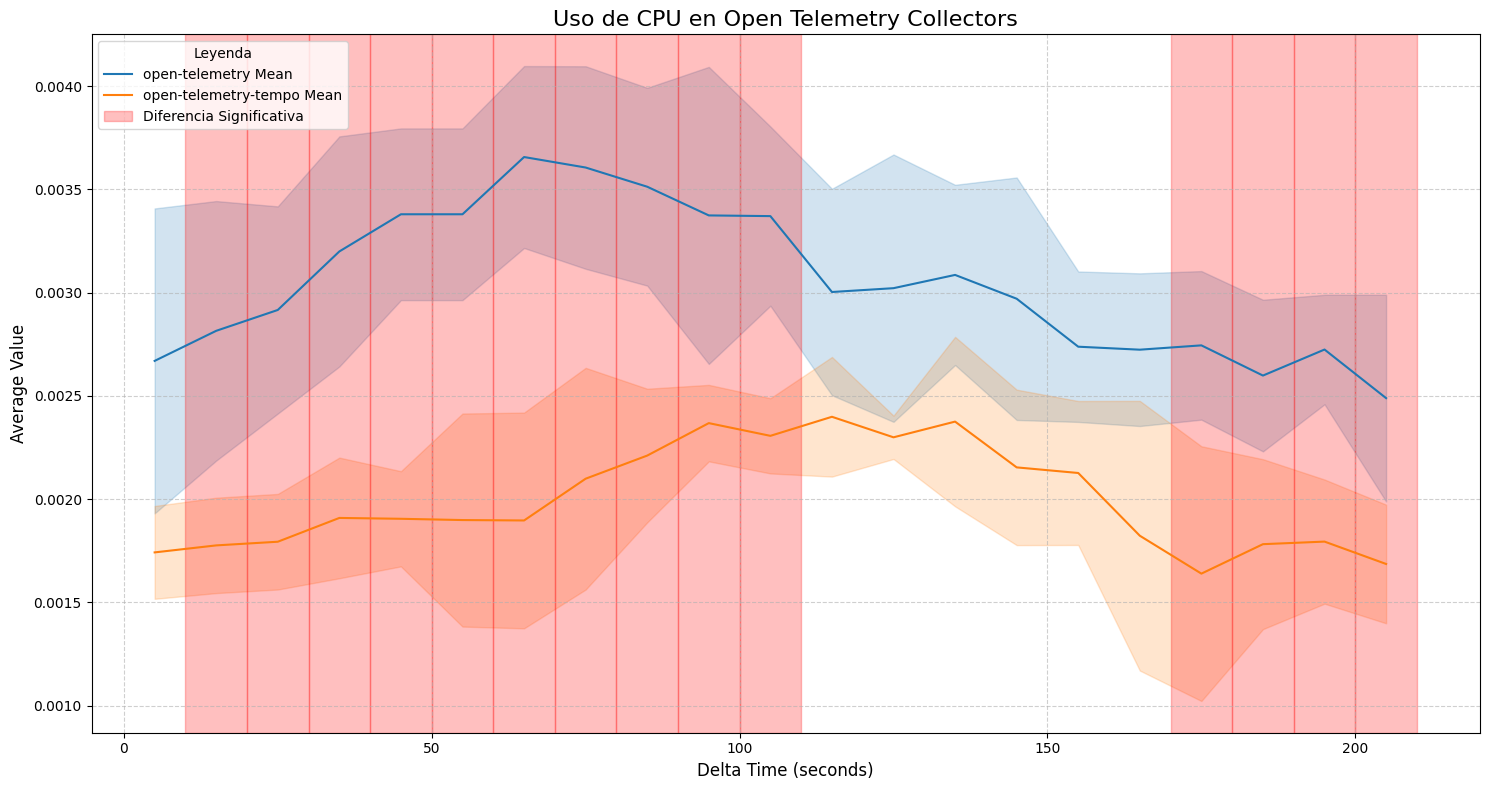

Empty DataFrame
Columns: []
Index: []


In [36]:
process(collectors_service_keys, 'Uso de CPU en Open Telemetry Collectors', df)

/var/folders/rh/j4bhqmdj3wxd1_tlvbyqdsrc0000gn/T/ipykernel_70673/2395979386.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_binned = df_filtered.groupby(['service', 'time_bin']).agg(


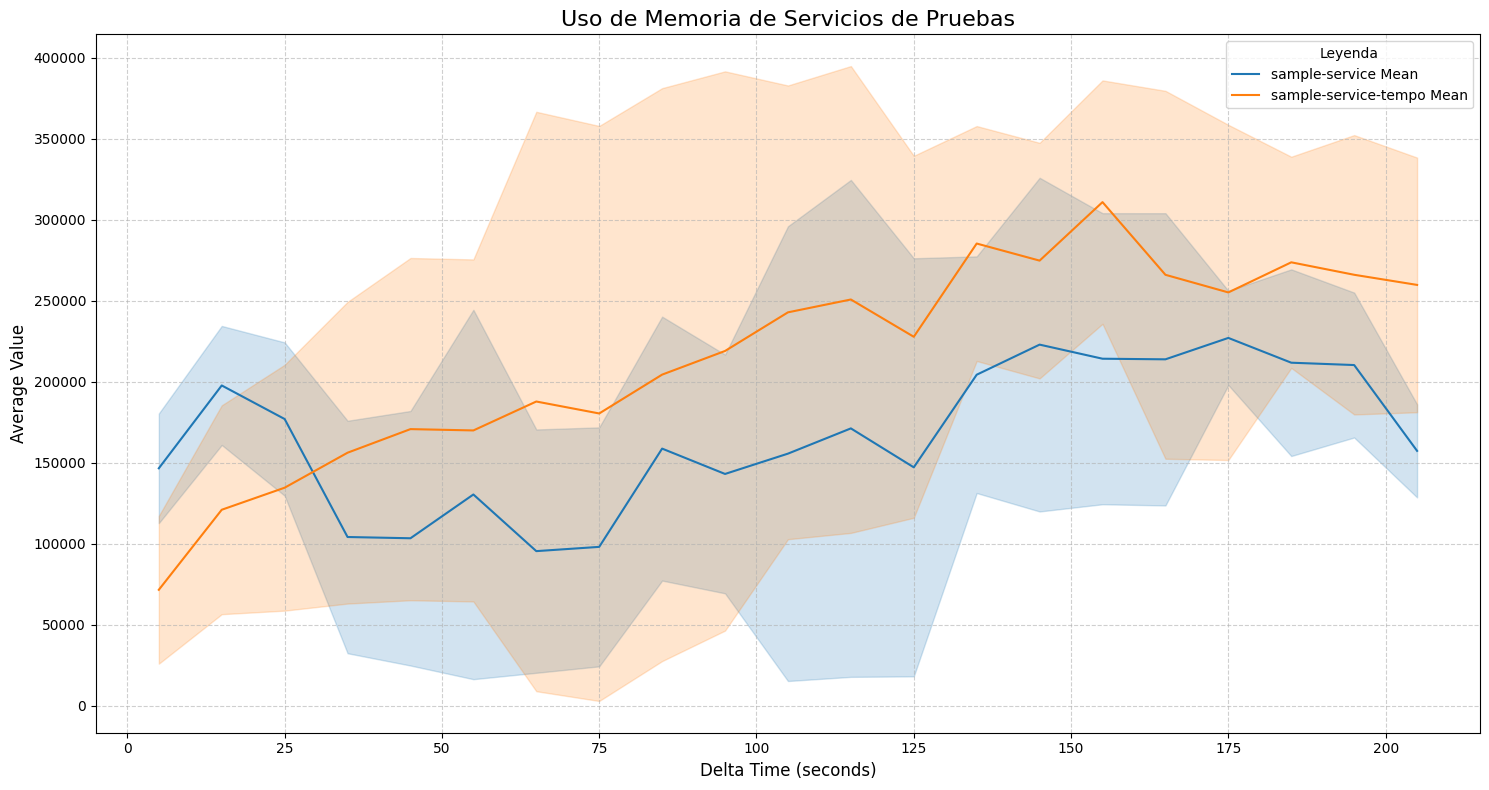

Empty DataFrame
Columns: []
Index: []


In [37]:
df = pd.read_excel('./separated-data/memory-usage.xlsx')
process(sample_service_keys, 'Uso de Memoria de Servicios de Pruebas', df)

/var/folders/rh/j4bhqmdj3wxd1_tlvbyqdsrc0000gn/T/ipykernel_70673/2395979386.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_binned = df_filtered.groupby(['service', 'time_bin']).agg(


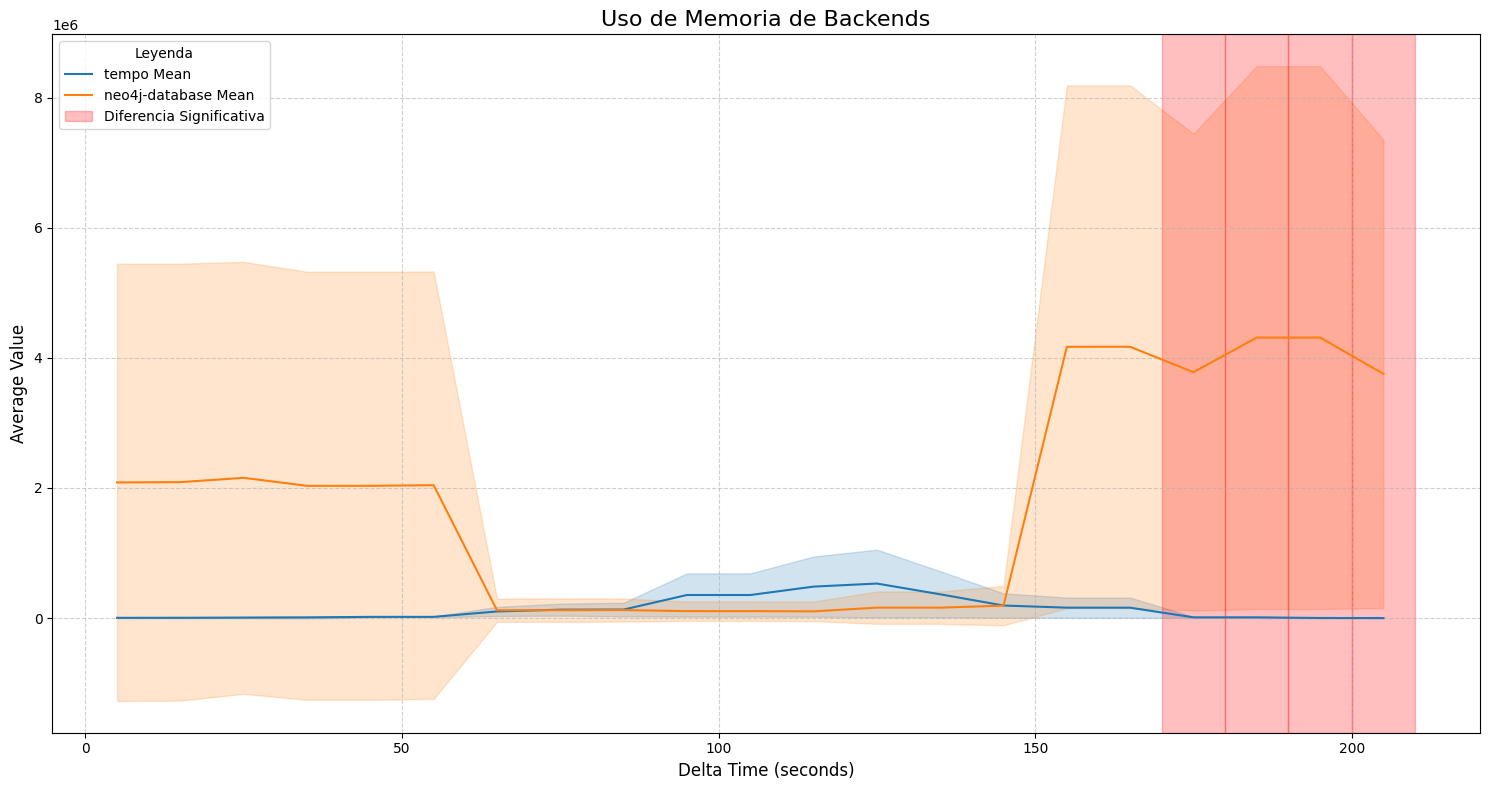

Empty DataFrame
Columns: []
Index: []


In [38]:
process(backend_service_keys, 'Uso de Memoria de Backends', df)

/var/folders/rh/j4bhqmdj3wxd1_tlvbyqdsrc0000gn/T/ipykernel_70673/2395979386.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_binned = df_filtered.groupby(['service', 'time_bin']).agg(


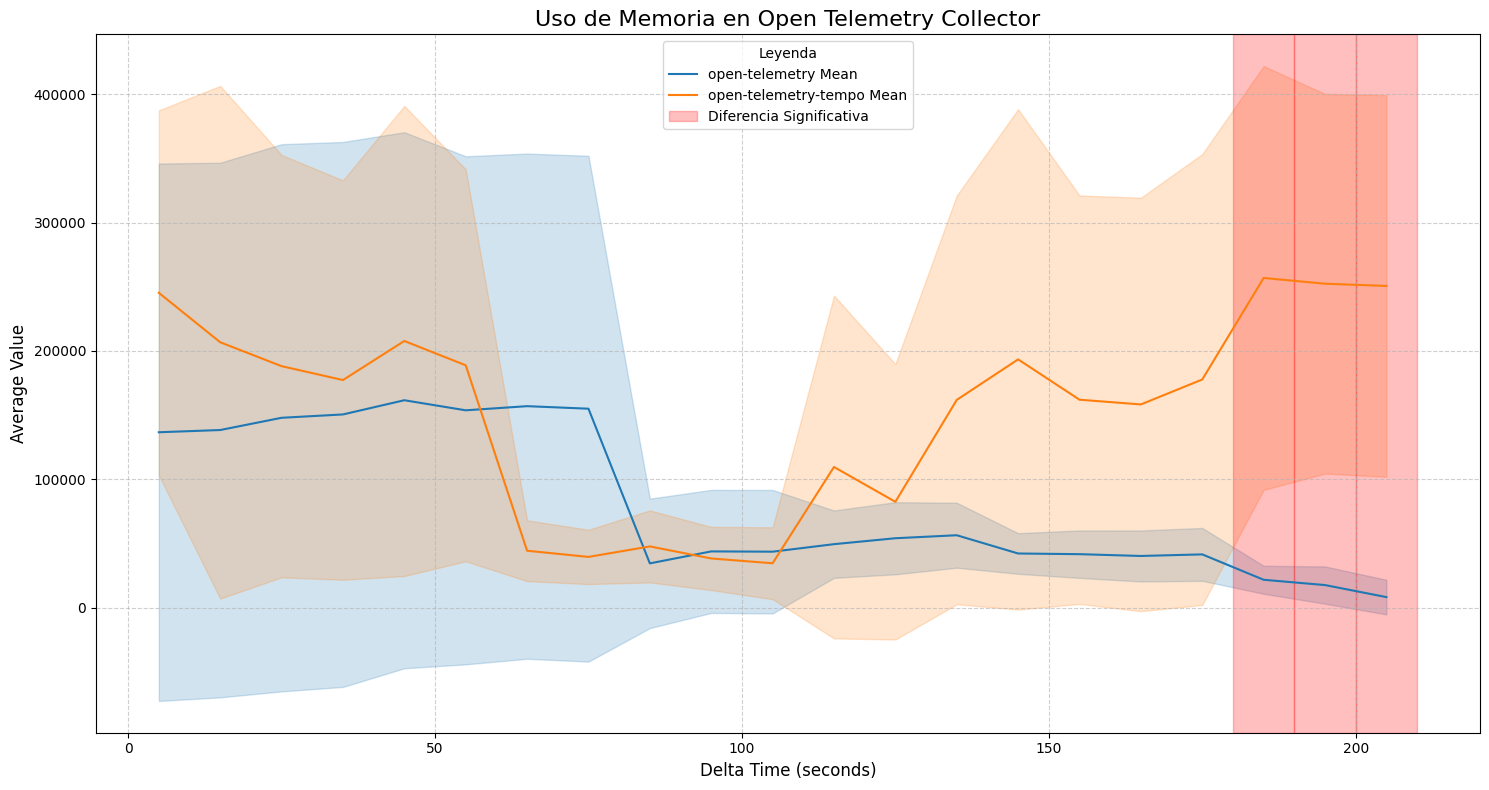

Empty DataFrame
Columns: []
Index: []


In [39]:
process(collectors_service_keys, 'Uso de Memoria en Open Telemetry Collector',  df)